# Sea surface temperature Canary

Plot the SST in the Canary Current Upwelling System.

In [3]:
import sys
sys.path.insert(0, '..')
import os
import glob
from filament import filament
import datetime
import netCDF4
import cmocean
import logging
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="f")
reload(filament)
plt.style.use("filament.mplstyle")

In [4]:
logger = logging.getLogger("filamentPlot")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 0

In [7]:
regionname= "Canary"
datadir = f"/home/ctroupin/data/SST/{regionname}/"

figdir = f"../figures/SST/{regionname}/"
visibledir = "/data/Visible/"
datafilelist = sorted(glob.glob(os.path.join(datadir, "SNPP_VIIRS.20240313T130000.L2.SST.NRT*")))
nfiles = len(datafilelist)
logger.info("Processing {} files".format(nfiles))
mediumdomain = (-19., -6., 25., 35.)
smalldomain = (-15., -9., 27., 33.)
tinydomain = (-12., -9., 29.5, 32.)
canarydomain = (-19., -13., 26., 30.)
smallmedseadomain = (-2.5, 0., 36., 37.)
medseadomain = (-0.5, 5.5, 37.5, 41.)
medseadomain = (1., 2., 39.5, 40.)
capeghirdomain = (-13.5, -8.5, 28.5, 33.0)
gulflion = (1.5, 7.7, 41., 44.0)

domain = gulflion

myproj = ccrs.Mercator(central_longitude=0.5 * (domain[0] + domain[1]), min_latitude=domain[2], 
                       max_latitude=domain[3])

INFO:filamentPlot:Processing 1 files


In [8]:
if not(os.path.exists(figdir)):
    os.makedirs(figdir)

## Loop on files

INFO:filamentPlot:Working on /home/ctroupin/data/SST/Canary/SNPP_VIIRS.20240313T130000.L2.SST.NRT.nc
INFO:filamentPlot:Level-2 data
/home/ctroupin/.virtualenvs/RandoGC/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ctroupin/.virtualenvs/RandoGC/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


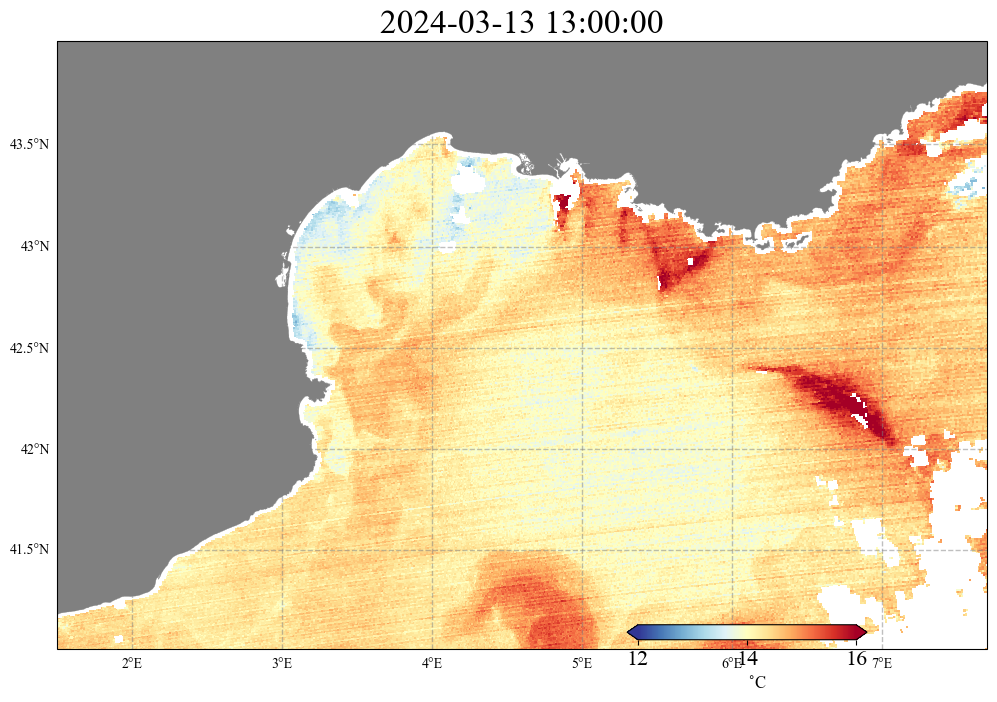

In [13]:
for ifile, datafile in enumerate(datafilelist):
    logger.info("Working on {}".format(datafile))
    
    #chloro = filament.Chloro()
    #chloro.read_from_oceancolorL2(datafile)
    
    
    with netCDF4.Dataset(datafile) as nc:
        proclevel = nc.processing_level
    sst = filament.SST()
    
    # Select the reader according to processing level
    if proclevel == "L3 Mapped":
        logger.info("Level-3 data")
        sst.read_from_oceancolorL3(datafile, coordinates)
    elif proclevel == "L2":
        logger.info("Level-2 data")
        sst.read_from_oceancolorL2(datafile)
        sst.field = np.ma.masked_where(sst.qflag > 1, sst.field)
        
    # Compute min and max values in the region of interest 
    # (to adapt the colorbar)
    #sstmin, sstmax = get_sst_limits(sst, [-18., -15., 27., 29.])
    sstmin, sstmax = 12., 16.
    
    figname = os.path.join(figdir, sst.get_figname())

    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(111, projection=myproj)
    ax.set_extent(domain)
    plt.title(sst.date.strftime("%Y-%m-%d %H:%M:%S"), fontsize=24)
    
    
    iii = 0
    #for tlon, tlat in zip(tracklon, tracklat):
    #    iii += 1
    #    ax.text(tlon, tlat, iii, horizontalalignment='center', verticalalignment='center',
    #        fontsize=15)
        
    #vis.add_to_plot(ax, myproj)
    #sst.field[sst.lat.data == -999.] = np.nan
    #sst.field[sst.lon.data == -999.] = nµp.nan
    #sst.lat[sst.lat.data == -999.] = np.nan
    #sst.lon[sst.lon.data == -999.] = np.nan
    
    #sst.lat = np.ma.masked_equal(sst.lat, -999.0, copy=True)
    #sst.lon = np.ma.masked_equal(sst.lon, -999.0, copy=True)
    sst.add_to_plot(fig, ax, domain=domain, cmap=plt.cm.RdYlBu_r,
                    clim=[sstmin, sstmax], vis=False,
                    cbarloc=[0.6, 0.2, 0.2, 0.015], alpha=1)
    
    ax.add_feature(coast, linewidth=.2, color=".5")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    plt.savefig(figname)
    plt.show()
    plt.close(fig)

In [19]:
def get_sst_limits(sst, domain=[-180., 180., -90., 90.]):
    valex = -32767.0
    
    goodlon = np.where( (sst.lon[:] <= domain[1]) & (sst.lon[:] >= domain[0]) )
    goodlat = np.where( (sst.lat[:] <= domain[3]) & (sst.lat[:] >= domain[2]) )
    goodcords = np.where( (sst.lon[:] <= domain[1]) 
                         & (sst.lon[:] >= domain[0]) 
                         & (sst.lat[:] <= domain[3]) 
                         & (sst.lat[:] >= domain[2]))
    sstdomain = sst.field[goodcords]
    goodvals = (sstdomain > 10.)
    sstmin = np.ceil(np.percentile(sstdomain[goodvals], 1.))
    sstmax = np.floor(np.percentile(sstdomain[goodvals], 99.))

    return sstmin, sstmax